# Прогнозирование успешности игры в следующем году.

**Цель исследования** - *выявить определяющие успешность игры закономерности и составить прогноз на следующий год.*

**Ход работы:**
1. *Загрузка данных*
2. *Предобработка данных (дубликаты, пропущенные значения, аномалии, выбивающиеся значения)*
3. *Категоризация данных по различным параметрам для дальнейшего анализа*
4. *Анализ данных (статистический и аналитическиий)*
5. *Проверка гипотез*

## 1. Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy import stats as st

In [2]:
try:
    data = pd.read_csv('games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')
# to run locally and on server

pd.set_option('display.max_columns', None) # displaying all the columns

In [3]:
display(data.head(10))
display(data.shape)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


(16715, 11)

## 2. Предобработка данных

#### 2.1. Привёдем названия столбцов к нижнему регистру.

In [4]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [5]:
data.columns = data.columns.str.lower()

In [6]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### 2.2. Избавление от дубликатов.

In [7]:
print(f"Amount of duplicates - {data.duplicated().sum()}")

Amount of duplicates - 0


Дубликаты не обнаружены.

#### 2.3. Обработаем пропуски.

In [8]:
display(data.isna().sum())
display(data.shape)

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

(16715, 11)

1. **`name`, `genre`, `year_of_release`** - мало пропусков, их можно удалить.
2. **`critic_score`, `rating`** - много пропусков из-за того, что игры могут быть непопулярными и на них банально не оставляли отзывов, а так же не такой большой процент людей вообще оставляет пропуски, поэтому заполним данные пропуски 0.
3. **`user_score`** - такая же причина, как и во 2м пункте, заполним 0, но здесь еще есть значения TBD (to be determined), данная оценка ставится, когда на игру слишком мало оценок от пользователей, чтобы сделать одну общую объективную оценку, поэтому ставят значение TBD, его заполним 0, это будет означать, что оценка не выставлена.

*Основная идея заполнения нулями состоит в том, чтобы в дальнейшем можно было построить гистограммы и посмотреть на распределения значений.*



In [9]:
data = data.dropna(subset = ['name', 'genre', 'year_of_release'])

data['critic_score'].fillna(0, inplace = True)
data['rating'].fillna('0', inplace = True)
data['user_score'].fillna('0', inplace = True)

data['user_score'] = data['user_score'].replace({'tbd' : '0'})

#### 2.4. Приведение данных к правильным типам.

In [10]:
data.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

- **`year_of_release`** - приведем к *int*, год не может быть дробным.
- **`critic_score`** - тоже приведем к *int*, потому что этот показатель оцениватеся в целых баллах.
- **`user_score`** - оценивается в 10-балльной шкале с дробными значениями, приведем к float.

In [11]:
data['year_of_release'] = data['year_of_release'].astype('int64')
data['critic_score'] = data['critic_score'].astype('int64')
data['user_score'] = data['user_score'].astype('float64')

#### 2.5. Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [12]:
def revenue(row):
    return row[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()

data['all_sales'] = data.apply(revenue, axis = 1)

Переместим новый столбец в середину после всех продаж по регионам.

In [13]:
data.columns.values

array(['name', 'platform', 'year_of_release', 'genre', 'na_sales',
       'eu_sales', 'jp_sales', 'other_sales', 'critic_score',
       'user_score', 'rating', 'all_sales'], dtype=object)

In [14]:
data = data[['name', 'platform', 'year_of_release', 'genre', 'na_sales',
       'eu_sales', 'jp_sales', 'other_sales', 'all_sales', 'critic_score',
       'user_score', 'rating']]

In [15]:
data.sample(6)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,all_sales,critic_score,user_score,rating
12009,Shounen Sunday x Shounen Magazine: Nettou! Dre...,DS,2009,Sports,0.00,0.00,0.07,0.00,0.07,0,0.0,0
12480,Speed,Wii,2010,Racing,0.04,0.02,0.00,0.01,0.07,0,0.0,E
2258,WWE SmackDown vs. Raw 2009,X360,2008,Fighting,0.58,0.26,0.00,0.08,0.92,79,7.1,T
7725,Sniper Elite,PS2,2005,Shooter,0.10,0.07,0.00,0.02,0.19,76,8.9,M
12749,Men in Black The Series: Crashdown,PS,2001,Shooter,0.03,0.02,0.00,0.00,0.05,0,0.0,0
6377,Ultimate NES Remix,3DS,2014,Action,0.15,0.09,0.00,0.02,0.26,69,7.6,E


## 3. Data Analysis

**План по анализу данных:**
- Посмотреть, сколько игр выпускалось в разные годы и дать оценку, исходя из графиков.
- Выяснить, как менялись продажи по платформам, исходя из года, города и др.
- Посмотреть, какой период является наиболее актуальным, записать в отдельный датасет.
- Какие платформы лидируют по продажам, растут или падают? Выбрать наиболее прибыльные.
- Описать глобальные продажи в зависимости от платформы.
- Посмотреть зависимость продаж от оценки критиков и пользователей.
- Определить самые прибыльные и неприбыльные жанры.

#### 3.1. Посмотрим, сколько игр выпускалось в разные годы.

In [16]:
temp = data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')
temp['year_of_release'] = temp.index
temp = temp.reset_index(drop = True)

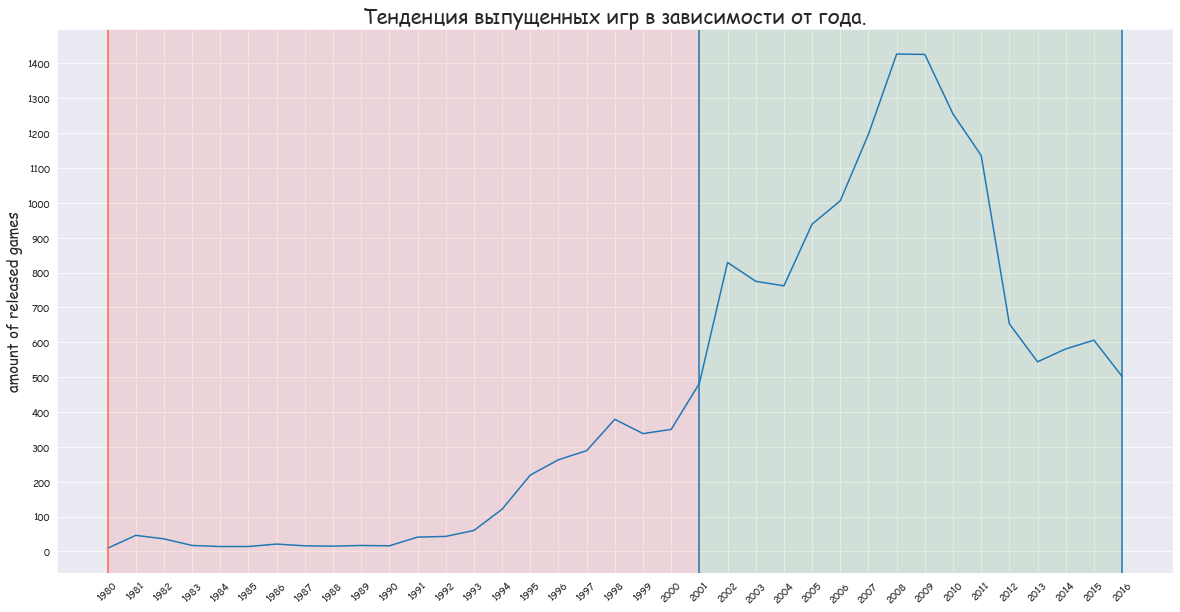

In [17]:
sns.set_style('darkgrid')
plt.figure(figsize = (20,10))
font = {'family' : 'fantasy',
        'size'   : 10}
plt.rc('font', **font)

sns.lineplot(data = temp, x = 'year_of_release', y = 'name')
plt.title('Тенденция выпущенных игр в зависимости от года.', fontsize = 20)

plt.xticks(range(1980, 2017, 1), rotation = 45)
plt.xlabel('')

plt.yticks(range(0,1500, 100))
plt.ylabel('amount of released games', fontsize = 15)

plt.axvline(x = 2001)
plt.axvline(x = 2016)
plt.axvline(x = 1980, color = 'tomato')

plt.axvspan(2001, 2016, alpha=0.1, color='green')
plt.axvspan(1980, 2001, alpha=0.1, color='red')


plt.show()

**Вывод:**

В основном большинство игр выпускалось с 2001 по 2016 год, возможно, мы можем пользоваться только этими данными, чтобы затем составить более точный анализ.

#### 3.2. Посмотрим, как менялись продажи по платформам.

In [18]:
temp1 = data.pivot_table(index = 'platform', values = 'all_sales', aggfunc = 'sum')
temp1['platform'] = temp1.index
temp1 = temp1.reset_index(drop = True).sort_values('all_sales', ascending = False)

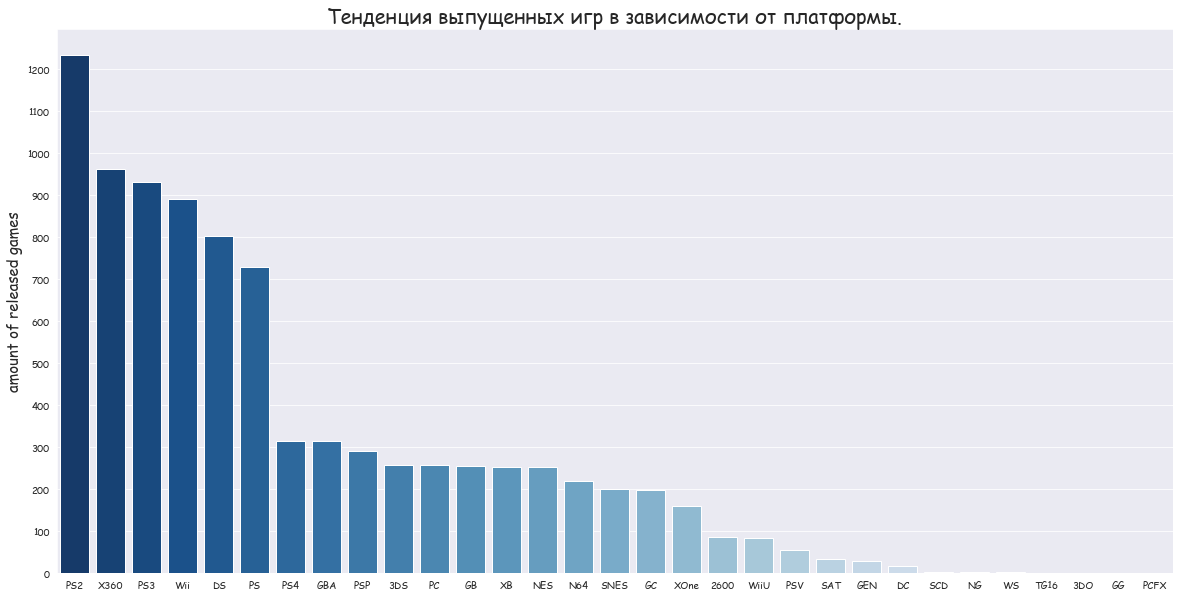

In [21]:
plt.figure(figsize = (20,10))

sns.barplot(data = temp1, x = 'platform', y = 'all_sales', palette = 'Blues_r')
plt.title('Тенденция выпущенных игр в зависимости от платформы.', fontsize = 20)

plt.xlabel('')
plt.ylabel('amount of released games', fontsize = 15)
plt.yticks(range(0,1300,100))

plt.savefig('output1.png')


plt.show()

**Вывод:**

Большинство игр было выпущено на 6 основных платформах, еще хочется взять **`PS4`**, потому что это самая современная платформа и скорее всего на ней тоже будет выходить много игр.

**Построим распределения для этих платформ.**

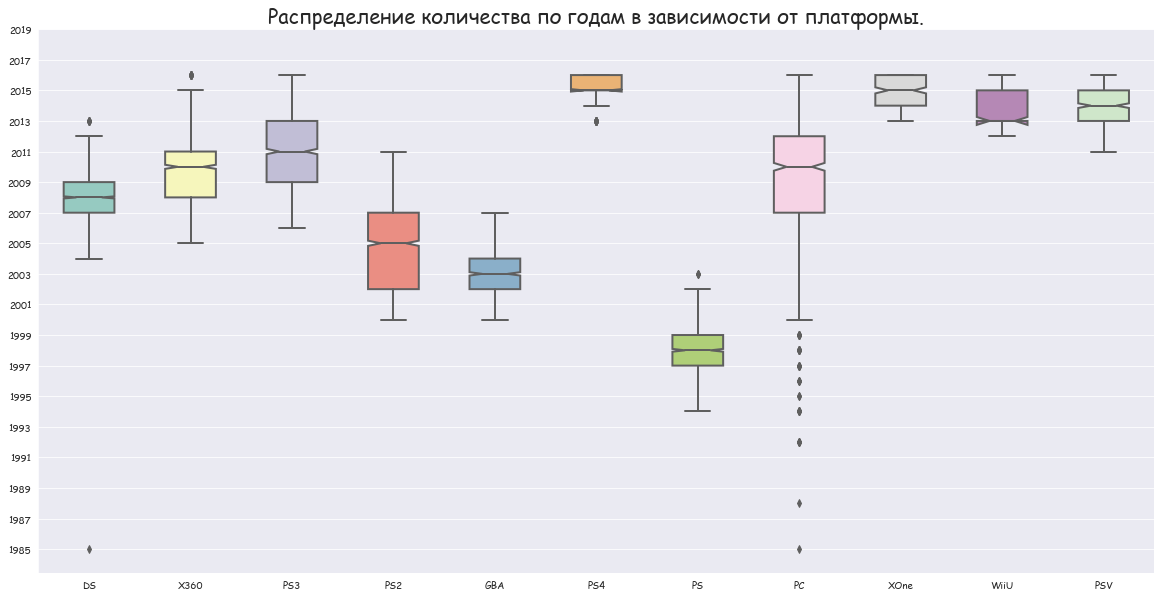

In [22]:
plt.figure(figsize = (20,10))

platforms = ['PS2', 'X360', 'PS3', 'DS', 'PS', 'PS4', 'GBA', 'PC', 'PSV', 'XOne', 'WiiU']
sns.boxplot(data = data.query('platform in @platforms'), x = 'platform', y = 'year_of_release', linewidth = 2,
                                                                                                notch = True,
                                                                                                width = 0.5,
                                                                                                palette = 'Set3')
plt.title('Распределение количества по годам в зависимости от платформы.', fontsize = 20)

plt.xlabel('')
plt.ylabel('')
plt.yticks(range(1985, 2020,2))

plt.show()

**Вывод:**

Так как мы хотим построить прогноз на 2017 год, то нам важно опираться на статистику предыдущего года и актуальные платформы, создадим новый актуальный датасет, с которым мы будем работать в дальнейшем.

#### 3.4. Собёрем новый датасет с актуальной информацией и продолжим дальнейшем анализ.

In [23]:
main = data.query('year_of_release == 2016 and platform in @platforms').reset_index(drop = True)

#### 3.5. Посмотрим на максимально прибыльные платформы.

In [24]:
temp2 = main.pivot_table(index = 'platform', values = 'all_sales', aggfunc = 'sum')
temp2['platform'] = temp2.index
temp2 = temp2.reset_index(drop = True).sort_values('all_sales',ascending = False)

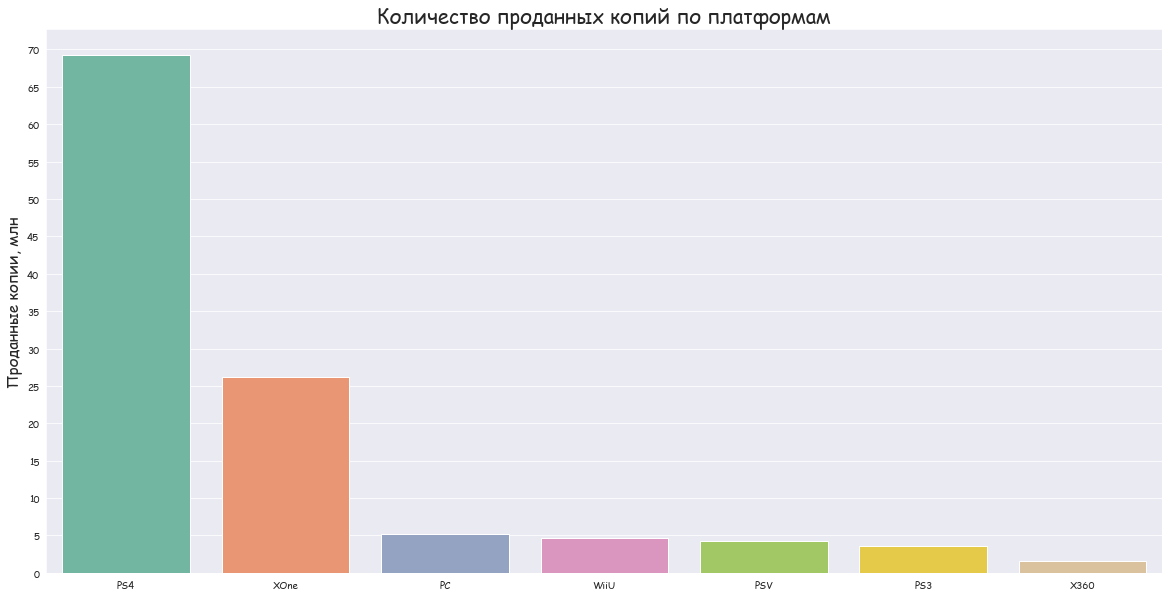

In [25]:
plt.figure(figsize = (20,10))

sns.barplot(data = temp2, x = 'platform', y = 'all_sales', palette = 'Set2')
plt.title('Количество проданных копий по платформам', fontsize = 20)

plt.yticks(range(0,75, 5))
plt.ylabel('Проданные копии, млн', fontsize = 15)
plt.xlabel('')


plt.show()

**Вывод:**

По сумме проданных копий в основном лидируют PS4 и XOne, теперь посмотрим на распределение по количеству.

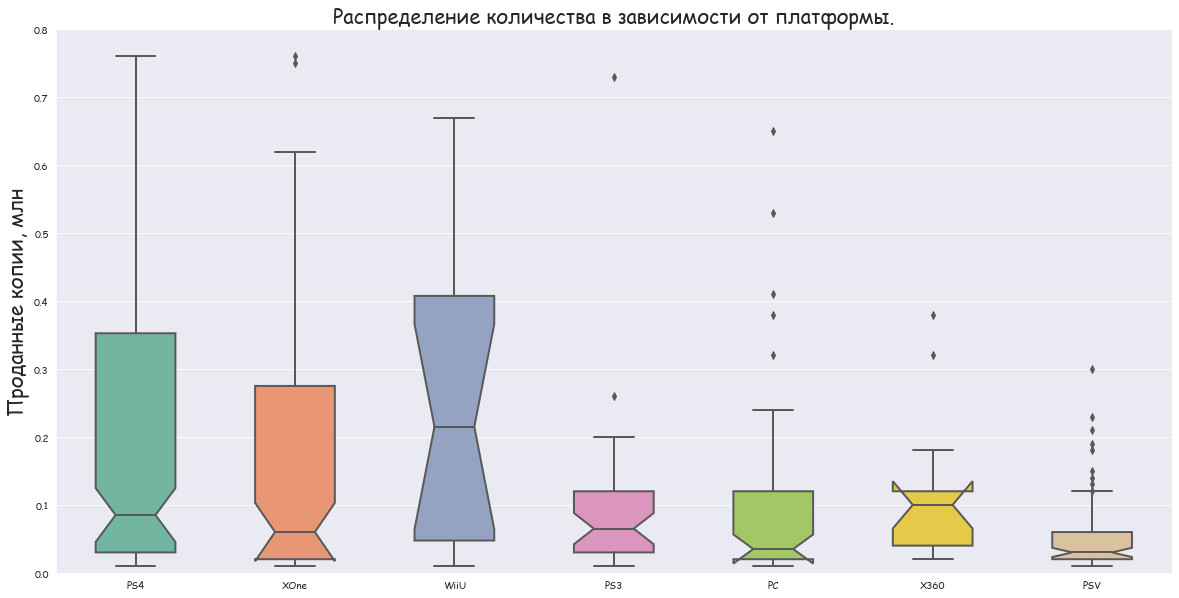

In [27]:
plt.figure(figsize = (20,10))

sns.boxplot(data = main, x = 'platform', y = 'all_sales', linewidth = 2, notch = True,
                                                                         width = 0.5,
                                                                         palette = 'Set2')
plt.title('Распределение количества в зависимости от платформы.', fontsize = 20)

plt.xlabel('')
plt.ylabel('Проданные копии, млн', fontsize = 20)

plt.ylim(0,0.8)

plt.savefig('output2.png')

plt.show()

**Вывод:**

В общем и целом гистограммы примерно находятся на одном уровне, по сравнению с первым графиком у WiiU не так много проданных копий, но количество игр, вышедших на нём, много.

#### 3.6. Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.
**За платформу возьмем *PS4*.**

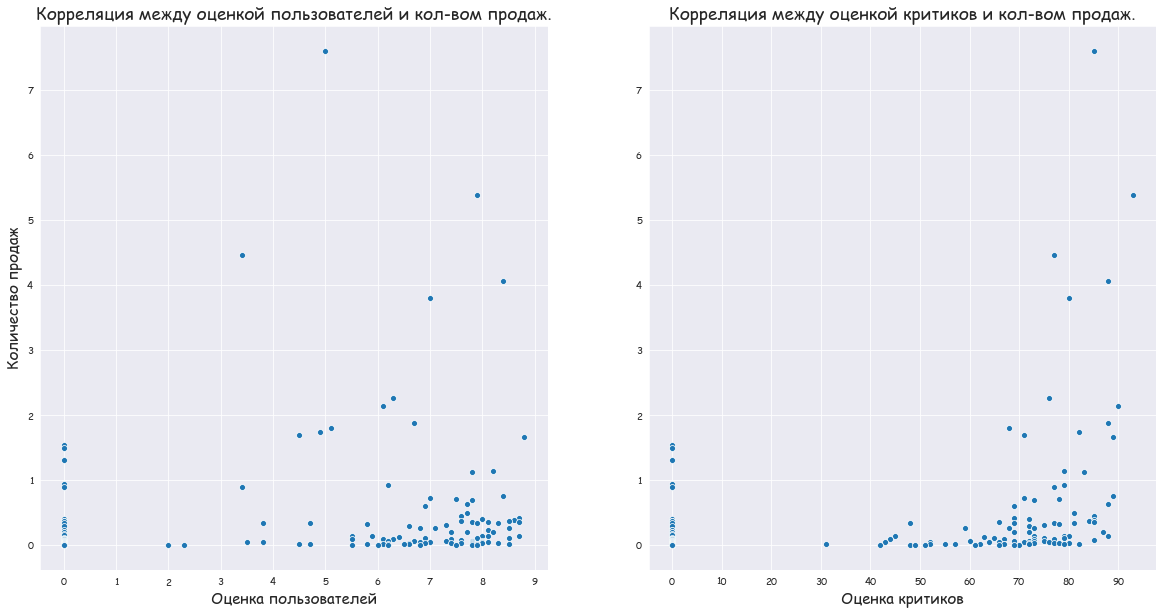

corr = 0.14709021832404173                                               corr = 0.2924512837698661


In [28]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
sns.scatterplot(data = main.query('platform == "PS4"'), x = 'user_score', y = 'all_sales')
plt.title('Корреляция между оценкой пользователей и кол-вом продаж.', fontsize = 17)

plt.xlabel('Оценка пользователей', fontsize = 15)
plt.ylabel('Количество продаж', fontsize = 15)
plt.xticks(range(0,10,1))


plt.subplot(1,2,2)
sns.scatterplot(data = main.query('platform == "PS4"'), x = 'critic_score', y = 'all_sales')
plt.title('Корреляция между оценкой критиков и кол-вом продаж.', fontsize = 17)

plt.ylabel('')
plt.xlabel('Оценка критиков', fontsize = 15)
plt.xticks(range(0,100,10))

plt.show()

print('corr =', main.query('platform == "PS4"')['all_sales'].corr(main.query('platform == "PS4"')['user_score']), end = ('                                               '))
print('corr =', main.query('platform == "PS4"')['all_sales'].corr(main.query('platform == "PS4"')['critic_score']) )

**Вывод:**

Явной прямой или обратной зависимости между величинами не наблюдается, можно сказать, что оценки критиков или пользователей не влияют на продажи.

#### 3.7. Посмотрим на общее распределение игр по жанрам.

In [29]:
temp3 = main.pivot_table(index = 'genre', values = 'all_sales', aggfunc = 'sum')
temp3['genre'] = temp3.index
temp3 = temp3.sort_values('all_sales', ascending = False).reset_index(drop = True)

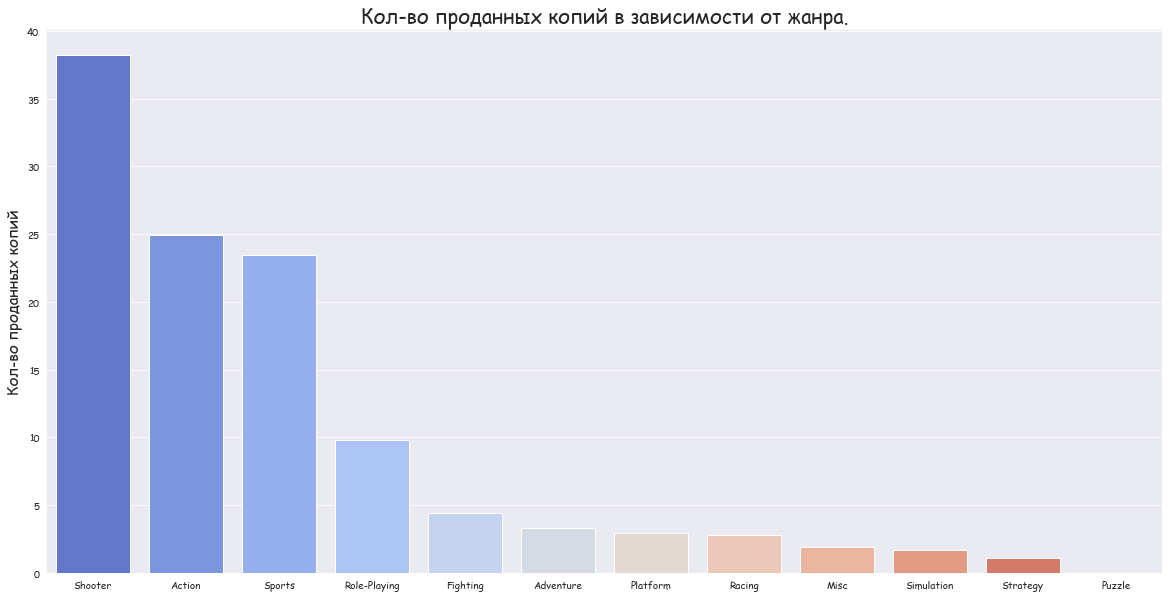

In [30]:
plt.figure(figsize = (20,10))

sns.barplot(data = temp3, x = 'genre', y = 'all_sales', palette = 'coolwarm')
plt.title('Кол-во проданных копий в зависимости от жанра.', fontsize = 20)

plt.xlabel('')
plt.ylabel('Кол-во проданных копий', fontsize = 15)


plt.show()

**Вывод:**

Самыми прибыльными жанрами являются `shooter`, `action` и `sports`, самыми неприбыльными являются `puzzle`, `strategy`, `simulation`.

## 4. Составим портрет пользователей каждого региона

Определим типичный портрет пользователя каждого региона **(NA, JP, EU)** и посчитаем следующие характеристики:

- ТОП5 самых популярных платформ.
- ТОП5 самых популярных жанров.
- Определим, влияет ли рейтинг ESRB на продажи в регионе.

#### 4.1. ТОП5 самых популярных платформ в каждом регионе.

Сначала преобразуем датасеты в нужные нам для анализа.

In [975]:
jp_platforms = main.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum')
jp_platforms['platform'] = jp_platforms.index
jp_platforms = jp_platforms.sort_values('jp_sales', ascending = False).reset_index(drop = True)

In [976]:
eu_platforms = main.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum')
eu_platforms['platform'] = eu_platforms.index
eu_platforms = eu_platforms.sort_values('eu_sales', ascending = False).reset_index(drop = True)

In [977]:
na_platforms = main.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum')
na_platforms['platform'] = na_platforms.index
na_platforms = na_platforms.sort_values('na_sales', ascending = False).reset_index(drop = True)

Нарисуем графики.

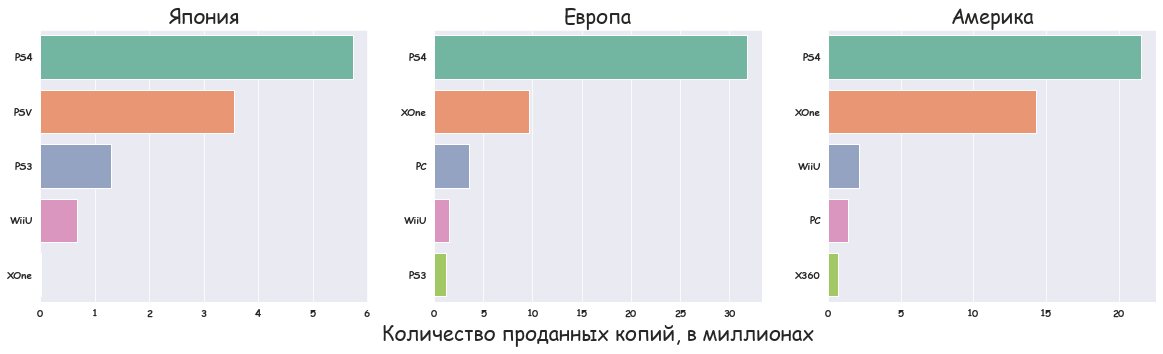

In [979]:
plt.figure(figsize = (20,5) )

plt.subplot(1,3,1)
sns.barplot(data = jp_platforms.head(), y = 'platform', x = 'jp_sales', palette = 'Set2')
plt.ylabel('')
plt.xlabel('')
plt.title('Япония', fontsize = 20)


plt.subplot(1,3,2)
sns.barplot(data = eu_platforms.head(), y = 'platform', x = 'eu_sales', palette = 'Set2')
plt.ylabel('')
plt.xlabel('Количество проданных копий, в миллионах', fontsize = 20)
plt.title('Европа', fontsize = 20)


plt.subplot(1,3,3)
sns.barplot(data = na_platforms.head(), y = 'platform', x = 'na_sales', palette = 'Set2')
plt.ylabel('')
plt.xlabel('')
plt.title('Америка', fontsize = 20)

plt.show()

**Выводы**:

- `PS4` - самая популярная платформа во всех регионах с больший отрывом.
- `Xone` - вторая по популярности платформа в Европе и Америке, но совсем непопулярная платформа в Японии.
- В общем и целом ситуация между Европой и Америкой отличается не сильно за исключением того, что в Европе чуть популярнее `PS3`, а в Америке `X360`.

- `WiiU` примерно на одинаковом среднем уровне популярности во всех странах.
- `PSV` на втором уровне популярности в Японии в то время как в других регионах, `PSV` не входит даже в ТОП5.

Такие разные доли продаж объясняются тем, что в Европе и Америки продают больше копий, чем в Японии, по крайней мере в данном датасете.

#### 4.2. ТОП5 самых популярных жанров в каждом регионе.

In [980]:
jp_genres = main.pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum')
jp_genres['genre'] = jp_genres.index
jp_genres = jp_genres.sort_values('jp_sales', ascending = False).reset_index(drop = True)

In [981]:
eu_genres = main.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum')
eu_genres['genre'] = eu_genres.index
eu_genres = eu_genres.sort_values('eu_sales', ascending = False).reset_index(drop = True)

In [982]:
na_genres = main.pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum')
na_genres['genre'] = na_genres.index
na_genres = na_genres.sort_values('na_sales', ascending = False).reset_index(drop = True)

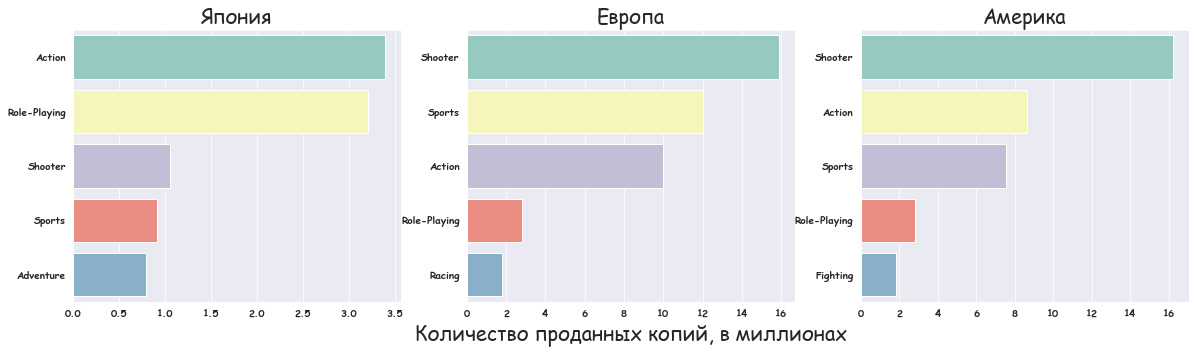

In [983]:
plt.figure(figsize = (20,5) )

plt.subplot(1,3,1)
sns.barplot(data = jp_genres.head(), y = 'genre', x = 'jp_sales', palette = 'Set3')
plt.ylabel('')
plt.xlabel('')
plt.title('Япония', fontsize = 20)


plt.subplot(1,3,2)
sns.barplot(data = eu_genres.head(), y = 'genre', x = 'eu_sales', palette = 'Set3')
plt.ylabel('')
plt.xlabel('Количество проданных копий, в миллионах', fontsize = 20)
plt.title('Европа', fontsize = 20)


plt.subplot(1,3,3)
sns.barplot(data = na_genres.head(), y = 'genre', x = 'na_sales', palette = 'Set3')
plt.ylabel('')
plt.xlabel('')
plt.title('Америка', fontsize = 20)

plt.show()

**Выводы**:
- В Европе и Америке преобладают практически одни и те же жанра за исключением того, что в Европе больше популярен `Racing`, а в Америке `Fighting`.
- `Adventure` в основном распространен только в Японии.
- `Role-Playing` в Японии гораздо популярнее, чем в Европе и Америке.
- `Shooter` лишь на 3м месте в Японии, в то время как в других регионах он находится на лидирующих позициях. 

## 5. Hypothesis testing

**Проверим 2 гипотезы:**

1. *Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.*
2. *Средние пользовательские рейтинги жанров `Action` и `Sports` разные.*

- Гипотезы будем проверять с помощью t-критерия на двух выборках из `main`.
- Оценивать будем по p-value. Уровень значимости зададим 5% или 0.05.

Мы считаем полученные значения именно выборками, а не ген. совокупностями, потому что данные за 2016 год у нас неполные, а значит они являются выборочными.

#### 5.1. Гипотеза:  Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

- **H₀** - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- **H₁** - Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

In [984]:
alpha = 0.05

sample_xbox = main.query('platform == "XOne"')['user_score']
sample_pc = main.query('platform == "PC"')['user_score']

result = st.ttest_ind(sample_xbox, sample_pc)

print(f"p-value = {result.pvalue}", end = '\n\n')
if result.pvalue < alpha:
    print("H0 gets denied.")
else:
    print("H0 doesn't get denied.")

p-value = 0.6452008993598132

H0 doesn't get denied.


Мы получили p-value равное **0.64**, это значит, что при принятии нулевой гипотезы, вероятность того, что средние значения равны - 64%. Из-за фундаментальных ограничений мы не можем принять ни принять, ни отвергнуть нулевую гипотезу, хоть вероятностное значение довольно большое.

#### 5.2. Гипотеза:  Средние пользовательские рейтинги жанров `Action` и `Sports` разные.

- **H₀** - Средние пользовательские рейтинги жанров `Action` и `Sports` одинаковые.
- **H₁** - Средние пользовательские рейтинги жанров `Action` и `Sports` разные.

In [985]:
alpha = 0.05

sample_action = main.query('genre == "Action"')['user_score']
sample_sports = main.query('genre == "Sports"')['user_score']

result = st.ttest_ind(sample_action, sample_sports)

print(f"p-value = {result.pvalue}", end = '\n\n')
if result.pvalue < alpha:
    print("H0 gets denied.")
else:
    print("H0 doesn't get denied.")

p-value = 0.10568744349331466

H0 doesn't get denied.


Такой же случай, мы не можем ни однозначно отвергнуть нулевую гипотезу, ни принять альтернативную из-за p-value > 0.05.

## 6. Вывод
Напомню цель исследования - **выявить определяющие успешность игры закономерности**.

**На что стоит ориентироваться при разработке / запуске / продаже игры (по убыванию приоритета):**
1. Регион. От региона зависит абсолютно всё, начиная от используемых платформ для игр, заканчивая жанрами этих игр.
2. Жанры. Не важно, какая будет платформа, если жанр будет непопулярным, то его не будут покупать на тех или иных платформах в регионах.
3. Платформа. Будет глупо выпускать что-то на Xbox One и рассчитывать на большой поток покупателей из Японии.
4. Оценки критиков и пользователей можно учесть, но они практически не влияют на кол-во продаж.

**Приблизительные прогнозы на успешные (прибыльные) игры в 2017 году:**

*Прогноз 1:*
- Рынок ориентирован на весь мир
- Жанр `Action` / `Shooter`
- Платформа `PS4`

*Прогноз 2:*
- Рынок ориентирован на EU и NA
- Жанр `Shooter`
- Платформа `XBox One`

*Прогноз 3:*
- Рынок ориентирован на JP
- Жанр `Role-playing`
- Платформы `PS4, PS3, PS Vita`